# households demo: modelling and household lifecycles #

**Andrew Cabaniss**
*Interdepartmental Program in Classical Art and Archaeology, University of Michigan, Ann Arbor, MI*

ahfc@umich.edu

Model construction has a long history in archaeology, but most models are still applied without explicit definition. In the realm of household archaeology, namely the study of the physical remains of houses and the attempts to reconstruct the social lives of their inhabitants, assumptions about the timescale of household growth and house renovation regularly rely on the temporality of events in the lifecycle. These assumptions are sometimes rooted in ethnographic observations of Mediterranean or world villages, while other times they are based on the author's intuition or personal experiences. Regardless of the justification, such models can be more profitably explored by explicit definition and construction. 

An explicit computational model of household lifecycles and house renovation can be constructed using the households Python package. I am writing this package to provide a consistent simulation toolbox for modelling ancient households as well as better understand the intersection between demographic processes and sociocultural transformations of daily life. The package is designed with comparability and easy parametrization in mind, making it possible to perform complex simulations which contrast individual and household lifecycle behaviors such as marriage, inheritance, fragmentation, and fusion.

At present, the simulation framework is set up to model homogeneous communities which collectively enact social structures such as neolocality, patrilineal inheritance, or fraternal rivalry. A forthcoming modification to this package will enable multiple communities to coexist as well as allow individuals who enter the simulation (via immigration or birth) to adopt, adapt, learn, or improvise new behaviors as well. At present, it is best suited for answering questions about the relationship between individual settled communities or villages and the temporality of architectural modifications, including renovation, construction, and abandonment.

This Jupyter Notebook is organized in two main sections. The first is a demonstration section that covers the main objects of the simulation as well as the yearly lifecourse of individuals and households. This uses toy data typical of the agent-based computational demography literature in which idealized lifecourses are used to represent the more complex demographics of empirically studied populations. The second part is a qualitative coherence assessment between empirically grounded demography of traditional Mediterranean populations and the architectural renovations, additions, and abandonments visible in the domestic architecture of the Early Iron Age (1200-700 BCE) Ierapetra Isthmus of Eastern Crete, Greece.


In [1]:
import os
os.chdir('./code')
from households import *
import pandas
import matplotlib.pyplot as plt

Importing the households package
Importing identity
importing kinship
importing residency
importing behavior
loading narrative
Importing main.py
importing inheritance
importing locality
importing fragmentation


## An Introduction to households: Sweetwater##

I center our exploration of the households package on the town of Sweetwater in the world of WestWorld (1). Sweetwater is a `Community`, meaning that it contains a collection of both Persons and Houses as well as a combination of demographic and behavioral rules. Almost all Persons live in Houses (`Person.has_house`), and almost all Houses that are lived in have an owner (`House.has_owner`). Further, all Persons can potentially have a spouse (`Person.has_spouse`) and may also have a further family of children and other relatives who can be accessed through the `kinship` module, while their household can be accessed and assessed through the `residency` module. This enables the articulation of different types of relationships between `Persons`, giving a "linked-lives" component to the model that would provide a suitable social network for analyses beyond household demography.

Beyond maintaining `Persons` and `Houses`, `Communities` define context- or event-specific rules (e.g. rules for where a newly married couple should live), time-specific rules (e.g. the probability an individual Person will give birth in a given year), and collections of objects (e.g. people). The community determines the birth and death rates of all Persons (`Community.birthtab`, `Community.mortab`) as well as the ages at which individuals become eligible for marriage (`Community.marrtab`). When individuals marry, the Community they live in defines in which house they will live (`Community.locality`); when individuals die, it determines how their property is divided (`Community.inheritance`); and when households grow in size or property changes hands, it determines whether the household splits (`Community.fragmentation`). At present, it is the Community of residence which determines the profile of an individual's lifecourse.

In the case of Sweetwater, life is short because of a very high mortality rate caused by violence. We can define this through the `AgeTable` class, which flexibly defines the probability of events occuring based on an individual's age and sex (2). In the case of Sweetwater, we can simplify this by defining male mortality to be low until age 20, at which point it is about a constant rate of 7.5% a year because of the bloodthirsty visitors. Female mortality is similarly dismal, but doesn't pick up until age 25. 

```
mortality = AgeTable(ages=[0,20,25,100],sex1 = male, rates1 = [0,.075,.075], sex2 = female, rates2 = [0,0,.075])
```

Eligibility for marriage is similarly defined. Here we assume that all Persons can become eligible for marriage at age 18, and have a 1/3 chance of become eligible in any given year. Spousal search is random across the entire community of eligible individuals of the other sex. (3)

```
eligibility = AgeTable(ages = [0,18,100], sex1 = female, rates1 = [0,.33], sex2 = male, rates2 = [0,.33])
```

The same data structure is also used for modelling birth rates, assuming that individuals are married and coresident (4). Birth rates are very low in Sweetwater, and here we assume a 10% yearly fertility rate, although women will rarely live to have the average expected number of children because of the high mortality rate.

```
fertility = AgeTable(ages = [0,15,44,100], sex1 = female, rates1 = [0,.1,0], sex2 = male, rates2 = [0,0,0])
```

Together, these AgeTables define the events that frame lifecourse of individuals. What AgeTables do not define is the resultant behaviors triggered by these lifecourse events.  These are defined by a subpackage, `behavior`. 

In [2]:
mortality = AgeTable(ages=[0,20,25,100],sex1 = male, rates1 = [0,.075,.1], sex2 = female, rates2 = [0,0,.075])
eligibility = AgeTable(ages = [0,18,100], sex1 = female, rates1 = [0,.33], sex2 = male, rates2 = [0,.33])
fertility = AgeTable(ages = [0,15,44,100], sex1 = female, rates1 = [0,.1,0], sex2 = male, rates2 = [0,0,0])

`behavior` articulates the rules Persons access when they live in a community and undergo a major life event, such as marriage, inheriting property, or dying. These include the location couples move to (`behavior.locality`), how property is distributed by inheritance (`behavior.inheritance`), and household fragmentation caused by internal conflicts or perception of external pressures (`behavior.fragmentation`). Inheritance is currently the most developed module, and the other modules will be brought in line with the new standards inheritance sets.

### Inheritance ###
When an agent dies, they follow the `Community.inheritance` rule. These rules must be a `behavior.inheritance.InheritanceRule`, which is a class defined to ensure that such rules are well-formatted. The most basic type of `InheritanceRule` constructs a rule in three steps:

1. Check property qualifications (`InheritanceRule.has_property()`)

   - This is to ensure that this individual even has property that can be inherited. Currently, inheritance only occurs for houses. `inheritance.has_property_houses` checks whether an individual owns at least one house; other forms of inheritance could involve multiple houses being inherited.


2. If they have property, attempt to find an heir and assign the property to them. (`InheritanceRule.rule()`)

   - This may fail if the individual who died has no heirs who are eligible to inherit. Otherwise, the property is transferred to an heir.


3. If inheritance fails, then another option must be used. (`InheritanceRule.failure()`)

   - This can include defaulting to collective ownership, no ownership, or random assignment. 


Together, these steps of a simple `InheritanceRule` provide a structure for the distribution of property after death. More complex inheritance behaviors can be articulated through the `InheritanceRuleComplex` subclass, which defines a modification that breaks apart the `rule()` into three substeps while retaining `.has_property()` and `.failure()` as the first and last steps:

2. If they have property, attempt to find an heir and assign the property to them. (`InheritanceRule.rule()`)

   a. Find heirs and return them in a ranked and grouped order (`InheritanceRuleComplex.find_heirs()`)

      - This returns the full subset of potential heirs in ranked order, allowing some individuals to be given equal claims or  allowing partible inheritance.

   b. Among the ranked and grouped heirs, exclude those who don't qualify. (`InheritanceRuleComplex.limit_heirs()`)
    
     - Heirs could be limited because of their marital status, property ownership, age, sex, or number of children, as well as more complex factors such as adoption.
    
   c. Distribute the propery among the heir or heirs. (`InheritanceRuleComplex.distribute_property()`)
    
     - One or more heirs are selected and the property or properties are distributed according to some pattern. This is also a place to enforce residency requirements, i.e. if inheritance depends on residigin in the inherited property.
      
Inheritance strategies can be fine tuned within this structure, allowing a wide range of flexible behaviors to be described and implemented by the household package. This flexible class structure can enable a researcher to define novel property transmission patterns, or even a new family of related inheritance behaviors by creating a new subclass similar to `InheritanceRuleComplex`. 

For the community of Sweetwater, we have no attested property transmission except for the vague implication that children of all sexes can inherit homesteads. A proposed `InheritanceRule` for Sweetwater could thus be defined as follows:

```
inherit_homestead = InheritanceRuleComplex(has_property = has_property_houses,
                                           find_heirs = find_heirs_children_oldest_to_youngest,
                                           limit_heirs = limit_heirs_none,
                                           distribute_property = distribute_property_to_first_heir_and_move_household,
                                           failure = failed_inheritance_no_owner)
```

This would define the property to be inherited as houses, order the deceased's children oldest to youngest, and give the property to the oldest living child. If there were no living children, the house defaults to having no owner. 

While such a class system is not yet implemented for locality and fragmentation, this is the current expansion of households that is under development (5). 

In [3]:
inherit_homestead = behavior.inheritance.InheritanceRuleComplex(has_property = behavior.inheritance.has_property_houses,
                                                                    find_heirs = behavior.inheritance.find_heirs_children_oldest_to_youngest,
                                                                    limit_heirs = behavior.inheritance.limit_heirs_none,
                                                                    distribute_property = behavior.inheritance.distribute_property_to_first_heir_and_move_household,
                                                                    failure = behavior.inheritance.failed_inheritance_no_owner)

### Locality ###

Locality is the only type of behavior explicitly modeled at present when a couple is married. The `Community.locality` rule determines which of the `behavior.locality` functions the couple will follow, such as patrilocality, matrilocality, or neolocality (6). These functions are predefined and are simply selected, with the exception of neolocality, which at present requires determing a sole owner of the new house.

```
locality = lambda husband, wife: neolocality(husband,wife,primary = female)
```

In [4]:
locality = lambda husband, wife: behavior.locality.neolocality(husband,wife,primary = female)

### Fragmentation ###

Fragmentation is a more complex situational behavior which arises when a household as a coresidential group splits, normally due to social or economic conflict. An example would be the split between two coresidential brothers, one of whom inherits the homestead when a patriarch dies and the other is left without inheritance. This may encourage the disinherited brother to move himself and his family into a new, smaller house, potentially creating a new lineage as well as a new transmissible homestead for his own children.

Fragmentation at present has only two options, `no_fragmentation` and `brother_loses_out`. The latter assumes that if the oldest of a set of brothers inherits the parents' house, the younger brothers above the age of majority feel the pressure to move out. This can be easily parametrized, assuming an age of majority of 18:

```
fragmentation = lambda house: brother_loses_out(house,age=18)
```

In [5]:
fragmentation = lambda house: behavior.fragmentation.brother_loses_out(house,age=18)

Collectively the functions in the `behavior` subpackage provide the agents of the community with responses to major life events. While currently their behavior is uniform and only depending upon their having experienced these events, the current goal is to make the agents more agentive rather than simply part of a microsimulation as the package is developed. At present, the package provides sufficient flexibility to start modeling the dynamics of particular small-scale, homogeneous communities.

The only parameters we have yet to specify is the characteristics of our starting population in the community of Sweetwater. This includes the number of `Houses`, the number of `Persons`, and the starting age of the population. The initial configuration of a new community is a floating population who lacks residency, and as such new houses are occupied as the population becomes eligible for marriage. To encourage this, the starting population is kept at a single age, defined to be around the period marriages would begin in the lifecourse. 

At present, houses only exist and cannot be built to or modified, so the best option is to provide more houses than are likely to be needed during the simulation.

A potential starting population then may be 100 people and 200 houses, with a starting age of 17 (since our age of majority for  marriage is 18, as defined above). 

```
start_pop = 100
start_area = 200
start_age = 17
```

All that is required to define the simulation is to combine these parameters into a single `Community` object, as well as provide it with a name.

```
sweetwater = Community(name = 'Sweetwater',
                       pop = start_pop,
                       area = start_area,
                       startage = start_age,
                       mortab = mortality,
                       marrtab = eligibility,
                       birthtab = fertility,
                       locality = locality,
                       inheritance = inherit_homestead,
                       fragmentation = fragmentation)
```

In [6]:
start_pop = 100
start_area = 200
start_age = 17

rd.seed(1237) #Used here to standardize the example code across runs.
sweetwater = Community(name = 'Sweetwater',
                       pop = start_pop,
                       area = start_area,
                       startage = start_age,
                       mortab = mortality,
                       marrtab = eligibility,
                       birthtab = fertility,
                       locality = locality,
                       inheritance = inherit_homestead,
                       fragmentation = fragmentation)

### The Year ###

The simulation of a `Community` is defined to progress on an annual timescale. During each year, the following events occur:

1. The order of `Persons` in the `Community` is randomized.
2. Consulting the `Community.mortab` `AgeTable`, some people die; these deaths trigger the defined `InheritanceRule`.
3. Households may fragment, depending on these inheritances.
4. Individuals who are eligible for marriage may marry each other; other individuals will become eligible.
5. Women who are married may give birth.
6. Statistics are calculated about the events of the year, and the year is progressed by one.

We can now progress (`Community.progress`) our simulation five years to see what happens during the initial configuration and setup of Sweetwater.

In [7]:
while sweetwater.year < 5:
    sweetwater.progress()

Using the `narrative` module, we can make individual households and people a bit easier to read than the abstract class objects of their underlying representation. Let's take a look at one of the recently married couples who now has a child:

In [8]:
h = [x for x in sweetwater.houses if len(x.people) >2][1] #2 at year 5 start
print('This house contains ' + narrative.census(h)+':')
for x in h.people:
    print(narrative.biography(x)) 
print(' ')
william, clementine, maeve = h.people

This house contains a nuclear household with 3 people residing owned by Clementine:
William is a living man, 22 years old, married with one child
Clementine is a living woman, 22 years old, married with one child
Maeve is a living woman, 2 years old, ineligible
 


In this family, William and Clementine married, with Clementine giving birth to a baby girl Maeve two years prior. At present, they seem a model nuclear family. Let's progress a decade and check in on this household again.

In [9]:
while sweetwater.year < 15:
    sweetwater.progress()
print('This house contains ' + narrative.census(h)+':')
for x in h.people:
    print(narrative.biography(x)) 
print('Everyone else:')
for x in [william, clementine]:
    print(narrative.biography(x)) 
print(' ')


This house contains a solitary household with 1 person residing owned by Maeve:
Maeve is a living woman, 12 years old, ineligible
Everyone else:
William is a dead man, 24 years old, married with one child
Clementine is a dead woman, 26 years old, widowed with one child
 


As Sweetwater is effectively a more violent version of Oregon Trail, both parents have died of either gunshots or dysentery. William died first at age 24, followed shortly thereafter by Clementine at age 26. The minimal infant and child mortality rate means that Maeve will live until at least 25, and will likely marry between now and then. She will spend most of her childhood on her own, as no form of adoption was implemented for this community. Notably, however, she already owns the house, as there is also no age of majority requirement to inherit property. 

Let's now progress into the future when Maeve is 15 years older.

In [14]:
while sweetwater.year < 30:
    sweetwater.progress()
print('This house contains ' + narrative.census(h)+':')
print('Maeve still owns this house, but lives elsewhere (neolocality after marriage!)')
print(' ')
h = maeve.has_house
robert = maeve.has_spouse
print('This house contains ' + narrative.census(h)+':')
for x in h.people:
    print(narrative.biography(x)) 
print(' ')
for x in [robert, maeve]:
    print(x.name + ' has ' + str(sum([g.owner==x for g in sweetwater.houses])) + ' house(s)')

This house contains a nuclear household with 3 people residing owned by Maeve:
Maeve still owns this house, but lives elsewhere (neolocality after marriage!)
 
This house contains a nuclear household with 3 people residing owned by Maeve:
Robert is a living man, 26 years old, married with one child
Maeve is a living woman, 27 years old, married with one child
Emily is a living woman, 3 years old, ineligible
 
Robert has 1 house(s)
Maeve has 2 house(s)


Maeve still owns her childhood home, but no longer lives in it. Following the community practice of neolocality, she now lives in a new home which she owns, along with her husband Robert and daughter Emily. Notably, Robert also inherited his childhood home before moving out when he married Maeve, and as such the family collectively controls 3 houses.

From observing individual families in this manner, we may arrive at some larger truths. The current pattern of 1) neolocality followed by 2) single inheritance makes it impossible for property to be distributed, only to concentrate, leading to substantial inequalities in the number of houses each household controls. This can be seen clearly in aggregate by anbalyzing all households currently present in the simulation:

24

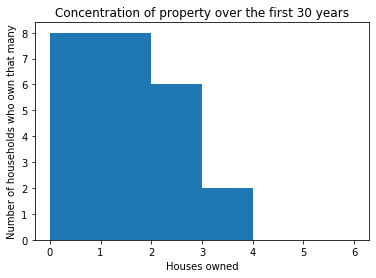

In [24]:

number_owned = []
for g in sweetwater.houses:
    if g.people != []:
        owned = 0
        for x in g.people:
            owned += sum([i.owner==x for i in sweetwater.houses])
        number_owned.append(owned)
plt.hist(number_owned,bins = [0,1,2,3,4,5,6])
plt.xlabel('Houses owned')
plt.ylabel('Number of households who own that many')
plt.title('Concentration of property over the first 30 years')
print('')

Property is slowly concentrating into the hands of those who didn't die young. In the grand scheme of problems Sweetwater is facing, however, the larger looming threat is the population collapse occuring because of mismatched death and birth rates, as there are only 24 households left from a starting population of 100 individuals.

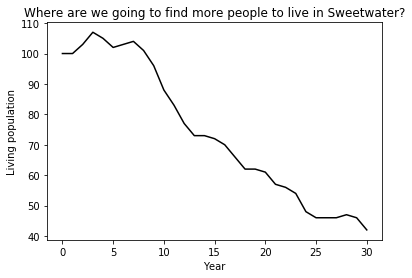

In [22]:
plt.plot(range(sweetwater.year+1),sweetwater.poplist,'k-')
plt.xlabel('Year')
plt.ylabel('Living population')
plt.title('Where are we going to find more people to live in Sweetwater?')
print('')

The household package provides a micro-simulation or micro-history view of individual households as well as macroviews of larger phenomena within particular communities. To better demonstrate this, I now turn from the fictional world of WestWorld to the real wilderness of Eastern Crete at the end of the Aegean Bronze Age, around 1200 BCE.

## East Crete and Iron Age Villages ##

Following a catastrophic reconfiguration of society that arose from multiple simutaneous natural and social causes, the late Bronze Aegean was transformed from a networked world of palaces and cities to a string of globally isolated yet locally connected villages. These villages were founded by the survivors of those collapsed cities and have several uniform properties that make them interesting to study socially. 

Most of these villages appear to be founded at the end of the Late Minoan III B period (XXXX-XXXX BCE, traditional chronology). aerly small foundation, quicker than growth (or too fragmentary?) they expand.

Agglomerative architecture with phases of rebuilding, appear to be related to the growth of nuclear families into extended household housing complexes, but also some evidence for later abandonment and shrinking

social structure often thought to involve clans or lineages, reflected in religious beliefs, ties to the past, and the preservation of architecture rahter than expanding into new houses

these communities move, agglomerate, and become new communities which take on urban characteristics (public space, formalized government/conflict resoluition.

characteristics of these communities would then be described as: lineage structure (patrilocal/matrilocal), housing expands to accomodate nuclear family units within the lineage, fragmentation appears to be rare, inheritance appears to encourage collective occupancy

### Architectural phasing ###

Many of the generalizations highlighted above are based on the detailed phasing of wall construction in houses.

how we detect these phases: architecture, features, stratigraphy, sometimes but rarely pottery

number of phases per period something we can extract, plus rooms added or housing units added


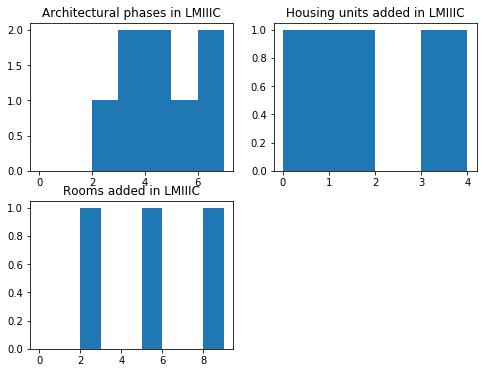

In [52]:
phases = pandas.read_excel('../data/housephases.xlsx')
lmiiic = phases.Period == 'LMIIIC'

fig, ((a,b),(c,d)) = plt.subplots(2,2)
fig.set_figheight(6)
fig.set_figwidth(8)

a.hist(phases.loc[lmiiic].PhasesCount,bins=range(8))
a.set_title('Architectural phases in LMIIIC')

b.hist(phases.loc[lmiiic].HousesEnd-phases.loc[lmiiic].HousesStart,bins=range(5))
b.set_title('Housing units added in LMIIIC')

c.hist(phases.loc[lmiiic].RoomsEnd-phases.loc[lmiiic].RoomsStart,bins=range(10))
c.set_title('Rooms added in LMIIIC')

d.axis('off')
print('')

like to run some community simulations that compare archaeological inferences with outcomes of the simulation as it stands

matrilocal vs neolocal
no fragmentation vs overcrowding fragmentation
matrilineal inheritance vs patrilineal 

some questions:
do phases correspond with # marriages? # births? # births of sons/daughters? do phases correspond with changes in ownership/inheritance? housing units with married couples? rooms with people?



## Footnotes ##

(1) Following the practice that most Python packages have some underlying theme (going back to Monty Python in the tutorials), the naming conventions for many classes and functions in households are based on the HBO series of WestWorld. This example is no exception.

This package tries to use "has_" nomenclature wherever possible, so that links from one object to another (e.g. from a Person to their spouse) uses the variable name "has_spouse", following from conventions in ontology creation.

Following Python nomenclature, classes are reffered to capitalized, such that a reference to a Person refers to the class that defines how individual people are represented and behave, while a reference to a person refers to an individual human being. 

(2) Future extensions will include alternative definitions of AgeTables. Sex is currently modeled as a binary variable, which is inaccurate and could be profitably changed in the future depending on the goal of the simulation.

(3) This will become a parameter (spousal_search) in the future, similar to the other modules of the behavior package.

(4) Future extensions will include the possibility of birth out of wedlock, as well as alternative household and family structures such as polyandry, polygamy, and non-co-residential spouses.

(5) The other expansion is more behavior modules, including behaviors triggered by marriage beyond locality, birth of first and subsequent children, and events triggered by the loss of children or spouses. Eventually, the goal is for the behavior subpackage to provide flexible ways of exploring different cultural norms and behavioral strategies that occur at the major moments of an individual's lifecourse.

(6) A next step is to enable a class system that will allow these to be prioritized, selected among stochastically, or variants such as settling in the wife's community but occupying a new house.

In [53]:
#Word count for personal tracking/page equivalents
## imported from https://gist.github.com/agounaris/5da16c233ce480e75ab95980831f459e
## credit to [agounaris](https://gist.github.com/agounaris)
import io
from IPython.nbformat import current

with io.open('../DEMO.ipynb', 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print(word_count)

3535


In [26]:
#Debugging inheritance classes
#behavior.inheritance.has_property_houses(clementine)
#behavior.inheritance.find_heirs_children_oldest_to_youngest(clementine) == [maeve]
#behavior.inheritance.limit_heirs_none([maeve]) == [maeve]
#behavior.inheritance.distribute_property_to_first_heir_and_move_household(clementine, [maeve])
#failure = behavior.inheritance.failed_inheritance_no_owner)
#clementine.has_community.inheritance._InheritanceRuleComplex__distribute_property(clementine,[maeve]) 